In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer, KBinsDiscretizer, LabelEncoder, MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use("ggplot")      
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


# from pandas_profiling import ProfileReport

# ProfileReport(train).to_notebook_iframe()

In [3]:
# 数据读取，删除无效列

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test1.csv')

train.drop(['Unnamed: 0'],axis=1,inplace=True)
test.drop(['Unnamed: 0'],axis=1,inplace=True)
train.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,316361,1199,46000.0,0.0,0.0,0.0,1,NaN,104,6.0,android,9,18,1438873,1.559893e+12,8,2135019403,0,2329670524,601
1,135939,893,0.0,0.0,0.0,0.0,1,NaN,19,6.0,android,8.1,0,1185582,1.559994e+12,4,2782306428,1,2864801071,1000
2,399254,821,0.0,760.0,0.0,360.0,1,NaN,559,0.0,android,8.1.0,0,1555716,1.559837e+12,0,1392806005,2,628911675,696
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,NaN,129,2.0,android,8.1.0,0,1093419,1.560042e+12,0,3562553457,3,1283809327,753
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,zh-CN,64,2.0,android,8.0.0,0,1400089,1.559867e+12,5,2364522023,4,1510695983,582


In [4]:
train.describe()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,media_id,ntt,package,sid,timestamp,location,fea1_hash,cus_type
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.00000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,5.000000e+05,500000.000000
mean,261359.275126,986.640110,40028.788034,1264.986626,72.027966,703.486166,0.48448,124.08762,3.089808,38.465876,1.500335e+06,1.559814e+12,96.040504,2.300866e+09,730.824682
std,233616.172774,128.956348,15460.788899,853.371330,167.664930,505.751343,0.49976,164.25454,1.843088,136.321129,2.884292e+05,1.680735e+08,85.652740,1.236593e+09,331.946854
min,0.000000,95.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,4.00000,0.000000,0.000000,1.000005e+06,1.559491e+12,-1.000000,1.240000e+04,297.000000
25%,0.000000,917.000000,46000.000000,720.000000,0.000000,360.000000,0.00000,29.00000,2.000000,0.000000,1.250850e+06,1.559664e+12,23.000000,1.376752e+09,411.000000
50%,228563.000000,1001.000000,46000.000000,1280.000000,0.000000,720.000000,0.00000,64.00000,2.000000,7.000000,1.500358e+06,1.559816e+12,64.000000,2.490131e+09,658.000000
75%,465701.500000,1076.000000,46000.000000,2040.000000,0.000000,1080.000000,1.00000,139.00000,5.000000,24.000000,1.750028e+06,1.559964e+12,154.000000,3.062465e+09,1019.000000
max,709898.000000,1241.000000,46003.000000,9024.000000,720.000000,8832.000000,1.00000,1544.00000,7.000000,2327.000000,1.999999e+06,1.560096e+12,330.000000,4.291920e+09,1380.000000


In [5]:
train.dtypes,len(train.columns)-1

(android_id      int64
 apptype         int64
 carrier       float64
 dev_height    float64
 dev_ppi       float64
 dev_width     float64
 label           int64
 lan            object
 media_id        int64
 ntt           float64
 os             object
 osv            object
 package         int64
 sid             int64
 timestamp     float64
 version        object
 fea_hash       object
 location        int64
 fea1_hash       int64
 cus_type        int64
 dtype: object,
 19)

android_id


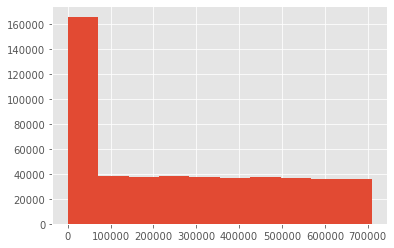

apptype


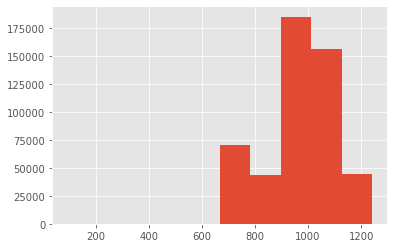

carrier


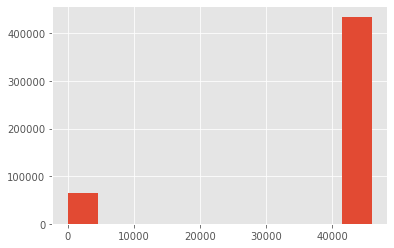

dev_height


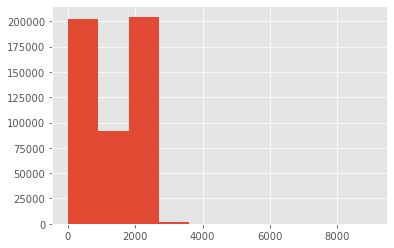

dev_ppi


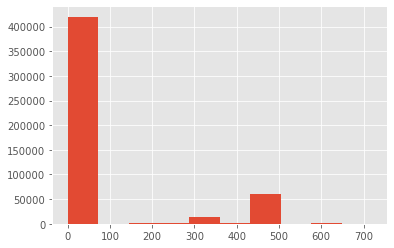

dev_width


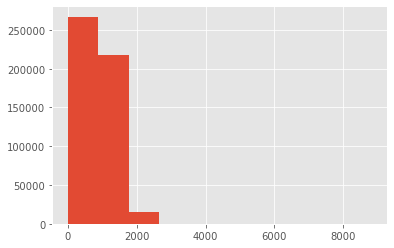

lan


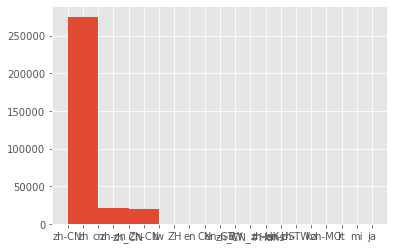

media_id


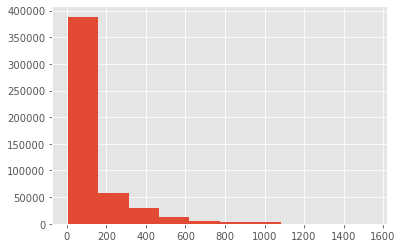

ntt


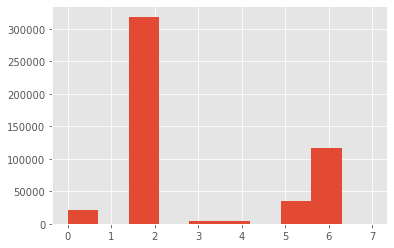

os


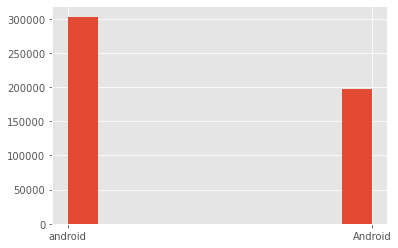

osv


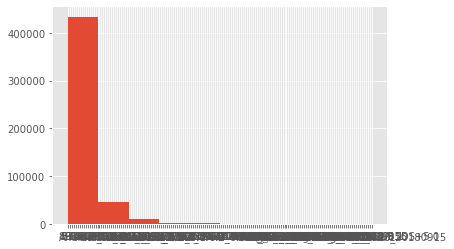

package


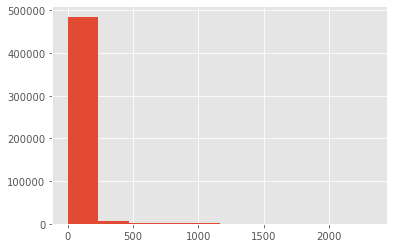

sid


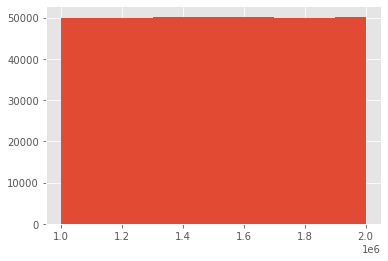

timestamp


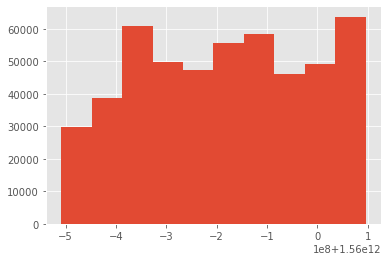

version


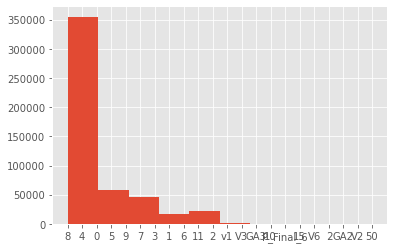

location


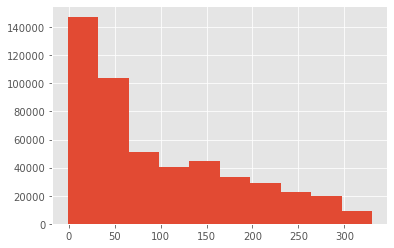

cus_type


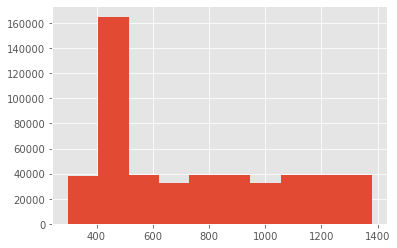

16


In [6]:
# 把各个特征的分布都用直方图画一下(除了fea_hash、fea1_hash、label)

fea_plt = train.columns.tolist()
fea_plt.remove('label')
fea_plt.remove('fea_hash')
fea_plt.remove('fea1_hash')

for i in range(len(fea_plt)):
    print('{}'.format(fea_plt[i]))
    train[fea_plt[i]].hist()
    plt.show();
print(i)    



# plt.figure()
# fig, axs = plt.subplots(4, 5, figsize=(18, 6))

# n = 0
# for i in range(4):
#     x=0
#     for j in range(5):   
#         axs[i][j].hist(train[fea_plt[x+n*5]])
#         axs[i][j].set_title('{}'.format(fea_plt[x+n*5]))
#         x+=1
#     n+=1

# fig.tight_layout();


<Figure size 864x720 with 0 Axes>

与label的相关性：


fea1_hash    -0.159327
package      -0.143005
android_id   -0.087281
cus_type     -0.072496
location     -0.027447
media_id     -0.027160
timestamp    -0.011059
sid           0.009815
dev_ppi       0.015442
dev_width     0.055805
ntt           0.064319
carrier       0.080065
dev_height    0.090912
apptype       0.109656
label         1.000000
Name: label, dtype: float64

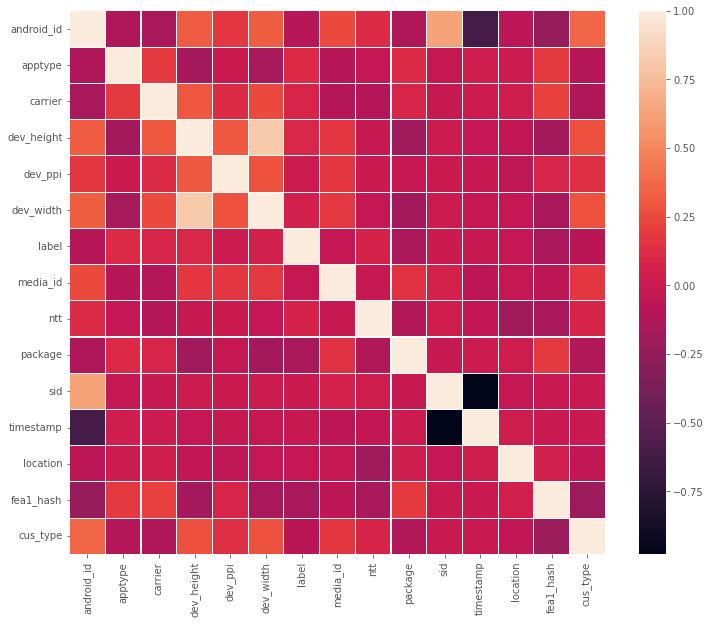

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(),linewidths = 0.05);

# 少了fea_hash，发现这列是str，并且有些奇怪的值
print('与label的相关性：')
train.corr().label.sort_values()

In [8]:
# 特征取值类别

for col in train.columns:
    col,train[col].nunique()

('android_id', 362258)

('apptype', 89)

('carrier', 5)

('dev_height', 798)

('dev_ppi', 92)

('dev_width', 346)

('label', 2)

('lan', 21)

('media_id', 284)

('ntt', 8)

('os', 2)

('osv', 154)

('package', 1950)

('sid', 500000)

('timestamp', 500000)

('version', 22)

('fea_hash', 402980)

('location', 332)

('fea1_hash', 4959)

('cus_type', 58)

特征处理

osv、version、timestamp、fea_hash、fea1_hash

In [9]:
data = pd.concat([train,test])

data.osv.unique()

array(['9', '8.1', '8.1.0', '8.0.0', '5.1', '9.0.0', '7.1.1', '5.1.1',
       '7.8.7', '4.4.4', nan, '6.0', '6.0.1', '3.9.0', 'Android_8.1.0',
       '7.0', '7.9.2', 'Android_9', '7.9.0', '7.1.2', '3.8.6', '5.1.0',
       '9.0', '7.7.7', '6.0.0', '5.0.2', 'Android_6.0.1', '7.0.0',
       '6.0_23', '4.2.2', '7.1', '8.0', '4.3', 'Android_8.0.0', '4.4.2',
       '4.1', 'Android_7.1.1', '5.0', 'Android_5.1.1', '2.3', '5.0.0',
       '7.8.0', '5.0.1', '4.4', '7.8.6', 'Android_5.1', 'Android_7.1.2',
       'Android_4.4.4', '8.0.1', '3.1.1', '7.7.2', '6.1', '3.8.4',
       '7.8.9', '7.7.5', '7.6.8', 'Android_7.0', '7.8.4', '7', '7.7.3',
       '7.1.0', '9.1', '4.1.1', 'Android_4.4.2', '3.8.0', '6.1.2',
       '7.2.1', '7.6.9', '3.7.8', '7.8.2', '8', '7910', '7.6.4', '7.8.5',
       '2.2.3', '5.2', 'Android_6.0', '4.2.1', '10.3.3', '4.0.2', '7.8.8',
       '4.4.3', '21100', '7.7.0', '4.0.3', '4.0.4', '5', '2.3.6', '6.1.0',
       '21000', '4.3.0', '4.1.2', '4.2', '7.6.7', '9.0.5', '4.4.2_19',


In [10]:
def handle_osv(osv):
    osv = str(osv).replace('.','').replace('W','').replace('Android_','').replace('Android', '').replace('十核20G_HD', '').replace(' ','')
    if osv=='nan' or osv=='GIONEE_YNGA': # 这2个值的前面的取值都为8.1.0
        result = 810
    elif osv=='f073b_changxiang_v01_b1b8_20180915':
        result = 810
    elif osv=='%E6%B1%9F%E7%81%B5OS+50':
        result=500
    elif osv.count('-')>0:
        result = int(osv.split('-')[0])
    else:
        result = int(osv)
    
    if result<10:
        result*=100
    elif result<100:
        result*=10
    
    return int(result)




data['osv'] = data['osv'].apply(handle_osv)     
data['osv'].unique()

array([  900,   810,   800,   510,   711,   511,   787,   444,   600,
         601,   390,   700,   792,   790,   712,   386,   777,   502,
        6023,   422,   710,   430,   442,   410,   500,   230,   780,
         501,   440,   786,   801,   311,   772,   610,   384,   789,
         775,   768,   784,   773,   910,   411,   380,   612,   721,
         769,   378,   782,  7910,   764,   785,   223,   520,   421,
        1033,   402,   788,   443, 21100,   770,   403,   404,   236,
       21000,   412,   420,   767,   905, 44219,   383,   433,   445,
         376,   235,   713,   303,   621,  5122, 60119,  7930,  4232,
         512,   774,   602,   431,   237,   530, 71200,   212,   766,
         234,   320,   110, 51122,   400,   731,   802,  5021,   201,
         429,  7920,   503,   292,   222, 60122,   446, 71300,   120],
      dtype=int64)

In [11]:
def handle_version(version):
    version = str(version).replace(' ','').replace('v','').replace('V','').replace('GA','').replace('P_Final_','').replace('GA','')
    return int(version)

data['version'] = data['version'].apply(handle_version)
data['version'].unique()
    

array([ 8,  4,  0,  5,  9,  7,  3,  1,  6, 11,  2, 10, 15, 50, 20],
      dtype=int64)

In [12]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder= LabelEncoder()
data['lan']=LabelEncoder.fit_transform(data['lan'])

data['lan'].unique()

array([24, 16, 15,  4, 21, 22,  3, 14,  2,  5,  0,  6,  1, 23, 17,  7, 19,
       12, 18, 10, 13, 11,  8, 20,  9])

In [13]:
import datetime
data['timestamp'] = data['timestamp'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000))

data['year']= data['timestamp'].dt.year
data['month']= data['timestamp'].dt.month
data['day']= data['timestamp'].dt.day
data['hour']= data['timestamp'].dt.hour
data['minute']= data['timestamp'].dt.minute
data['weekday']= data['timestamp'].dt.weekday

data.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,fea_hash,location,fea1_hash,cus_type,year,month,day,hour,minute,weekday
0,316361,1199,46000.0,0.0,0.0,0.0,1.0,24,104,6.0,...,2135019403,0,2329670524,601,2019,6,7,15,32,4
1,135939,893,0.0,0.0,0.0,0.0,1.0,24,19,6.0,...,2782306428,1,2864801071,1000,2019,6,8,19,40,5
2,399254,821,0.0,760.0,0.0,360.0,1.0,24,559,0.0,...,1392806005,2,628911675,696,2019,6,6,23,58,3
3,68983,1004,46000.0,2214.0,0.0,1080.0,0.0,24,129,2.0,...,3562553457,3,1283809327,753,2019,6,9,8,59,6
4,288999,1076,46000.0,2280.0,0.0,1080.0,1.0,16,64,2.0,...,2364522023,4,1510695983,582,2019,6,7,8,28,4


In [14]:
# fea_hash 有5w多个不同的取值,大多数就10位，大于10位的就处理成-1

train['fea_hash'].apply(len).quantile([.1,.2,.5,.75,.95])
data['fea_hash'] = data['fea_hash'].map(lambda i:-1 if len(str(i))>10 else int(i))
data['fea_hash_len'] = data['fea_hash'].map(lambda i:len(str(i)))

0.10     9.0
0.20     9.0
0.50    10.0
0.75    10.0
0.95    10.0
Name: fea_hash, dtype: float64

In [15]:
# fea1_hash 大多数就10位，大于10位的就处理成-1

train['fea1_hash'].astype('str').map(len).quantile([.1,.2,.5,.75,.95])
data['fea1_hash'] = data['fea1_hash'].map(lambda i:-1 if len(str(i))>10 else int(i))
data['fea1_hash_len'] = data['fea1_hash'].map(lambda i:len(str(i)))

0.10     9.0
0.20     9.0
0.50    10.0
0.75    10.0
0.95    10.0
Name: fea1_hash, dtype: float64

In [20]:
# # os处理

# data['os'] = LabelEncoder.fit_transform(data.os)

data['osv_ver'] = data['osv'] - data['version']

In [21]:
data.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,cus_type,year,month,day,hour,minute,weekday,fea_hash_len,fea1_hash_len,osv_ver
0,316361,1199,46000.0,0.0,0.0,0.0,1.0,24,104,6.0,...,601,2019,6,7,15,32,4,10,10,892
1,135939,893,0.0,0.0,0.0,0.0,1.0,24,19,6.0,...,1000,2019,6,8,19,40,5,10,10,806
2,399254,821,0.0,760.0,0.0,360.0,1.0,24,559,0.0,...,696,2019,6,6,23,58,3,10,9,810
3,68983,1004,46000.0,2214.0,0.0,1080.0,0.0,24,129,2.0,...,753,2019,6,9,8,59,6,10,10,810
4,288999,1076,46000.0,2280.0,0.0,1080.0,1.0,16,64,2.0,...,582,2019,6,7,8,28,4,10,10,795


In [18]:
def train_lgb_kfold(X_train, y_train, X_test, n_fold=5):
    '''train lightgbm with k-fold split'''
    gbms = []
    kfold = StratifiedKFold(n_splits=n_fold, random_state=2021, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))

    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        dtrain = lgb.Dataset(X_tr, y_tr)
        dvalid = lgb.Dataset(X_val, y_val, reference=dtrain)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 64,
            'learning_rate': 0.02,
            'min_data_in_leaf': 150,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.7,
            'n_jobs': -1,
            'seed': 2021
        }

        gbm = lgb.train(params,
                        dtrain,
                        num_boost_round=100,
                        valid_sets=[dtrain, dvalid],
                        verbose_eval=50,
                        early_stopping_rounds=20)

        oof_preds[val_index] = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        test_preds += gbm.predict(X_test, num_iteration=gbm.best_iteration) / kfold.n_splits
        gbms.append(gbm)

    return gbms, oof_preds, test_preds



In [19]:
def train_lgb(train, test, feat_cols, label_col, n_fold=10):
    '''训练lightgbm'''
    X_train = train[feat_cols]
    y_train = train[label_col]
    X_test = test[feat_cols]
    gbms_lgb, oof_preds_lgb, test_preds_lgb = train_lgb_kfold(X_train, y_train, X_test, n_fold=n_fold)
    
    return gbms_lgb, oof_preds_lgb, test_preds_lgb


In [28]:
train = data[data.label.notnull()]
test = data[data.label.isnull()].drop(['label'],axis=1)


# 获取time_diff
start_time1 = train['timestamp'].min()
train['timestamp_diff'] = train['timestamp']-start_time1
train['timestamp_diff'] = train['timestamp_diff'].dt.days - train['timestamp_diff'].dt.seconds/3600/24

start_time2 = test['timestamp'].min()
test['timestamp_diff'] = test['timestamp']-start_time2
test['timestamp_diff'] = test['timestamp_diff'].dt.days - test['timestamp_diff'].dt.seconds/3600/24



In [ ]:
feat_cols = ['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width',  'lan', 'media_id', 'ntt', 'os', 'osv', 'package',
       'sid',  'version', 'fea_hash', 'location', 'fea1_hash',
       'cus_type', 'year', 'month', 'day', 'hour', 'minute', 'weekday',
       'fea_hash_len', 'fea1_hash_len', 'osv_ver', 'timestamp_diff']

In [29]:
gbms_lgb, oof_preds_lgb, test_preds_lgb = train_lgb(train, test,
                                                    feat_cols=feat_cols,
                                                    label_col='label')


[LightGBM] [Info] Number of positive: 218016, number of negative: 231984
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484480 -> initscore=-0.062100
[LightGBM] [Info] Start training from score -0.062100
Training until validation scores don't improve for 20 rounds
[50]	training's auc: 0.929453	valid_1's auc: 0.929688
[100]	training's auc: 0.932944	valid_1's auc: 0.933092
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.932944	valid_1's auc: 0.933092
[LightGBM] [Info] Number of positive: 218016, number of negative: 231984
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011667 seconds.
You can set `force_row_wise=true` to remove the

In [30]:
# 划分阈值

def gen_thres_new(df_train, oof_preds):
    df_train['oof_preds'] = oof_preds
    quantile_point = df_train['label'].mean() 
    thres = df_train['oof_preds'].quantile(1 - quantile_point) # 比如 0,1,1,1 mean=0.75 1-mean=0.25,也就是25%分位数取值为0

    _thresh = []
    for thres_item in np.arange(thres - 0.2, thres + 0.2, 0.01): #  按照理论阈值的上下0.2范围，0.01步长，找到最佳阈值，f1分数最高对应的阈值即为最佳阈值
        _thresh.append(
            [thres_item, f1_score(df_train['label'], np.where(oof_preds > thres_item, 1, 0), average='macro')])

    _thresh = np.array(_thresh)
    best_id = _thresh[:, 1].argmax() # 找到f1最高对应的行
    best_thresh = _thresh[best_id][0] # 取出最佳阈值

    print("阈值: {}\n训练集的f1: {}".format(best_thresh, _thresh[best_id][1]))
    return best_thresh

In [32]:
lgb_thres =  gen_thres_new(train, oof_preds_lgb)

阈值: 0.46830601551613943
训练集的f1: 0.8759688534206158


In [33]:

def gen_submit_file(df_test, test_preds, thres, save_path):
    df_test['test_preds_binary'] = np.where(test_preds > thres, 1, 0)  
    df_test_submit = df_test[['sid', 'test_preds_binary']]
    df_test_submit.columns = ['sid', 'label']
    print(f'saving result to: {save_path}')
    df_test_submit.to_csv(save_path, index=False)
    print('done!')
    return df_test_submit



df_test_res = pd.DataFrame({'sid': test['sid'],
                                'test_preds_lgb': test_preds_lgb})

df_test_res['lgb_rank'] = df_test_res['test_preds_lgb'].rank(pct=True)
df_test_res['preds'] =  np.where(df_test_res['lgb_rank']>lgb_thres,1,0)

# 结果产出
df_submit = gen_submit_file(df_test_res, df_test_res['preds'], lgb_thres,
                            save_path='./result.csv')

saving result to: ./result.csv
done!
